In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%load_ext autoreload
%autoreload 2

In [2]:
from tqdm.notebook import tnrange, tqdm
from jax import random, vmap, jit, value_and_grad
from jax.experimental import optimizers, stax
import jax.numpy as np
import staxplusplus as spp
from normalizing_flows import *
from util import *
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from mpl_toolkits.mplot3d import Axes3D

# Create the dataset

In [3]:
key = random.PRNGKey(0)
k1, k2 = random.split(key, 2)

z_line = np.linspace(-10, 10, 1000)
t = np.sort(random.t(k1, df=6, shape=(10000,)))#random.normal(k1, (10000,))*1.5
x, y = np.cos(t), np.sin(t)
x_line, y_line = np.cos(z_line), np.sin(z_line)
x = np.array([x, y, t]).T
x += random.normal(k2, x.shape)*0.1
x = onp.array(x)
onp.random.shuffle(x)
x = np.array(x)

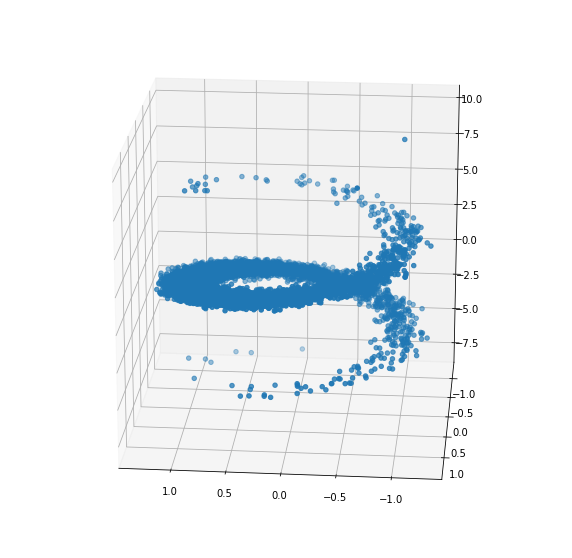

In [4]:
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(20, 95)
ax.scatter(x[:,0], x[:,1], x[:,2])

# Build the normalizing flow

In [5]:
# def Transform(out_shape, n_hidden_layers=4, layer_size=1024):
#     out_dim = out_shape[-1]
#     # Build the s and t networks that xb will be fed into
#     layer_sizes = [layer_size for _ in range(n_hidden_layers)]
#     log_s_out = spp.sequential(spp.Dense(out_dim), spp.Tanh())
#     t_out = spp.sequential(spp.Dense(out_dim))
#     dense_layers = [spp.Dense(layer_size), spp.Relu()]*n_hidden_layers
#     coupling_param_architecture = spp.sequential(*dense_layers, spp.FanOut(2), spp.parallel(log_s_out, t_out))

#     # Split x into xa, xb and feed xb into its path
#     return coupling_param_architecture


# intermediate_flow = sequential_flow(AffineCoupling(Transform),
#                                     Reverse(),
#                                     AffineCoupling(Transform),
#                                     Reverse(),
#                                     AffineCoupling(Transform),
#                                     Reverse(),
#                                     AffineCoupling(Transform),
#                                     Reverse(),
#                                     AffineCoupling(Transform),
#                                     Reverse(),
#                                     TallAffine(UnitGaussianPrior(), 1))

n_layers = 9
flow = sequential_flow(MAF([1024]*n_layers),
                       UnitGaussianPrior())

flow = sequential_flow(MAF([1024]*n_layers),
                       Reverse(),
                       MAF([1024]*n_layers),                        
                       Reverse(),
                       MAF([1024]*n_layers),
                       Reverse(),                 
                       MAF([1024]*n_layers),    
                       Reverse(),                 
                       TallAffine(flow, 1))

flow_full_rank = sequential_flow(MAF([1024]*n_layers),
                                 Reverse(),
                                 MAF([1024]*n_layers),
                                 Reverse(),
                                 MAF([1024]*n_layers),
                                 Reverse(),                                 
                                 MAF([1024]*n_layers),
                                 Reverse(),
                                 MAF([1024]*n_layers),
                                 UnitGaussianPrior())

# Initialize the model

In [6]:
@partial(jit, static_argnums=(0,))
def nll(forward, params, state, x, **kwargs):
    cond = ()
    log_px, z, updated_state = forward(params, state, np.zeros(x.shape[0]), x, cond, **kwargs)
    l2_loss = np.linalg.norm(ravel_pytree(params)[0])
    return -np.mean(log_px) + 0.05*l2_loss, updated_state

def run_experiment(flow, key, n_iters):
    init_fun, forward, inverse = flow
    forward = jit(forward)

    input_shape = x.shape[1:]
    condition_shape = ()
    cond = ()

    names, output_shape, params, state = init_fun(key, input_shape, condition_shape)
    
    # Create the gradient function
    valgrad = value_and_grad(partial(nll, forward), has_aux=True)
    valgrad = jit(valgrad)
    
    # Create the optimizer
    opt_init, opt_update, get_params = optimizers.adam(0.001)
    opt_update = jit(opt_update)
    opt_state = opt_init(params)
    
    # Train
    batch_size = 128

    losses = []
    pbar = tnrange(n_iters)
    for i in pbar:
        key, *keys = random.split(key, 3)

        batch_idx = random.randint(keys[0], (batch_size,), minval=0, maxval=x.shape[0])
        x_batch = x[batch_idx,:]

        params = get_params(opt_state)
        (val, state), grad = valgrad(params, state, x_batch, key=keys[1])
        opt_state = opt_update(i, grad, opt_state)

        losses.append(val)
        pbar.set_description('Negative Log Likelihood: %5.3f'%(val))
        
    plt.plot(losses)
    return params, state

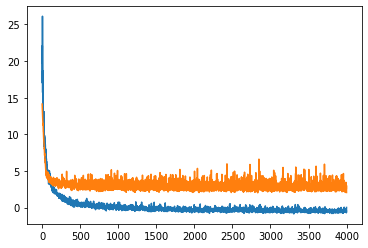

In [7]:
key = random.PRNGKey(0)
_, key2 = random.split(key, 2)
params, state = run_experiment(flow, key, 4000)
full_params, full_state = run_experiment(flow_full_rank, key2, 4000)

In [8]:
def get_samples(flow, params, state, z_dim=1, sigma=0.1):
    init_fun, forward, inverse = flow

    # Pull some samples from a unit Gaussian
    eps = random.normal(key, (5000, z_dim))
    log_px, f_eps, _ = inverse(params, state, np.zeros((5000,)), eps, (), test=TEST, key=key, sigma=sigma)
    px = np.exp(log_px)

    return f_eps, px

def get_likelihood(flow, params, state, x, sigma=0.1, **kwargs):
    init_fun, forward, inverse = flow

    # Pull some samples from a unit Gaussian
    log_px, _, _ = forward(params, state, np.zeros(x.shape[0]), x, (), test=TEST, key=key, sigma=sigma, **kwargs)
    px = np.exp(log_px)

    return px

In [9]:
manifold_samples, manifold_px = get_samples(flow, params, state, z_dim=1, sigma=0.0)
samples, _ = get_samples(flow, params, state, z_dim=1, sigma=0.05)
px = get_likelihood(flow, params, state, samples, n_importance_samples=32)
full_samples, full_px = get_samples(flow_full_rank, full_params, full_state, z_dim=3)

data_px_full = get_likelihood(flow_full_rank, full_params, full_state, x[:5000])
data_px_mine = get_likelihood(flow, params, state, x[:5000])

Text(0.5, 0.92, 'Learned Manifold')

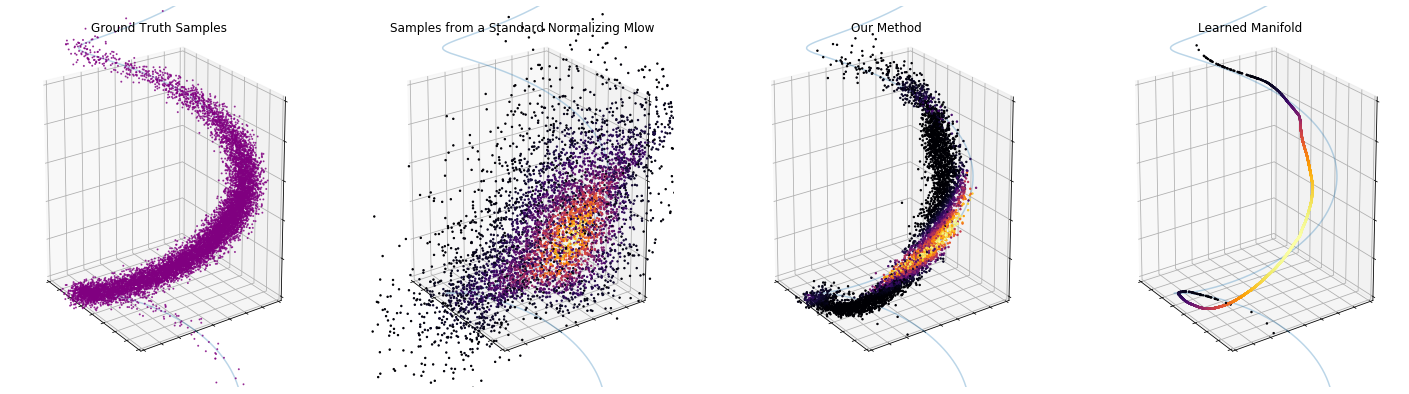

In [10]:
def plot_data(samples, px, ax, cmap='inferno', ground_truth=False):
    
#     ax.view_init(20, 90)
    ax.view_init(20, -35)
#     ax.view_init(30, 5)

    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])
    for line in ax.xaxis.get_ticklines():
        line.set_visible(False)
    for line in ax.yaxis.get_ticklines():
        line.set_visible(False)
    for line in ax.zaxis.get_ticklines():
        line.set_visible(False)

    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-2, 3)
    
    if(not ground_truth):
        ax.scatter(samples[:,0], samples[:,1], samples[:,2], alpha=1.0, s=2, c=px, cmap=cmap)
    else:
        ax.scatter(x[:,0], x[:,1], x[:,2], color='purple', alpha=0.7, s=1)
    ax.plot(x_line, y_line, z_line, alpha=0.3)
        
    return ax

fig = plt.figure()
fig.set_size_inches(25, 7)
ax = fig.add_subplot(141, projection='3d')
ax = plot_data(None, None, ax, ground_truth=True)
ax.set_title('Ground Truth Samples')

ax = fig.add_subplot(142, projection='3d')
ax = plot_data(full_samples, full_px, ax)
ax.set_title('Samples from a Standard Normalizing Mlow')

ax = fig.add_subplot(143, projection='3d')
ax = plot_data(samples, px, ax)
ax.set_title('Our Method')

ax = fig.add_subplot(144, projection='3d')
ax = plot_data(manifold_samples, manifold_px, ax)
ax.set_title('Learned Manifold')

Text(0.5, 0.92, 'Our likelihood')

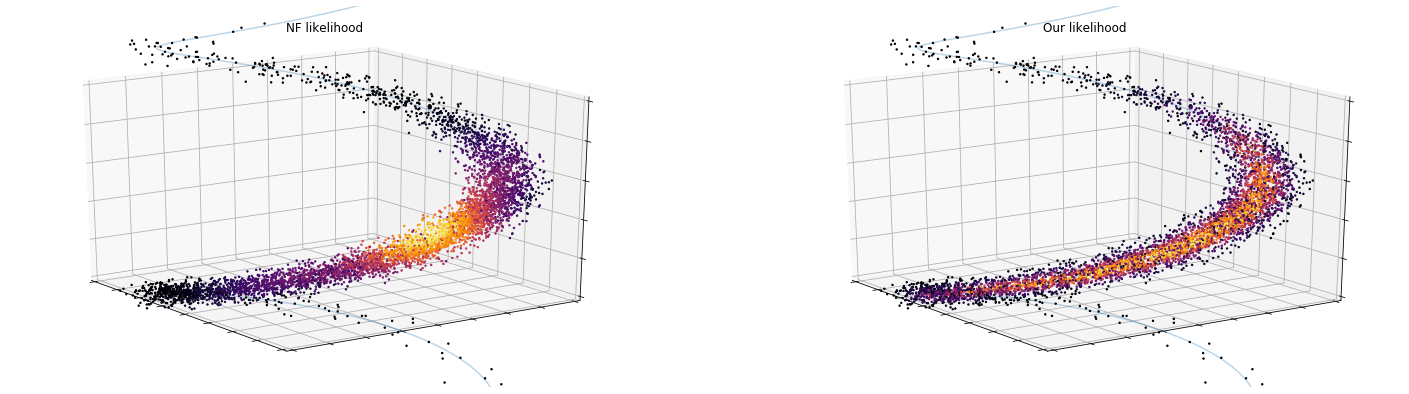

In [11]:
fig = plt.figure()
fig.set_size_inches(25, 7)
ax = fig.add_subplot(121, projection='3d')
ax = plot_data(x[:5000], data_px_full, ax)
ax.set_title('NF likelihood')

ax = fig.add_subplot(122, projection='3d')
ax = plot_data(x[:5000], data_px_mine, ax)
ax.set_title('Our likelihood')

In [15]:
init_fun, forward, inverse = flow
log_px, z, _ = forward(params, state, np.zeros((5000,)), x[:5000], (), test=TEST, key=key, sigma=0.1)
log_pfz, fz, _ = inverse(params, state, np.zeros((5000,)), z, (), test=TEST, key=key, sigma=0.1)

Text(0.5, 0.92, 'Original, original pdf')

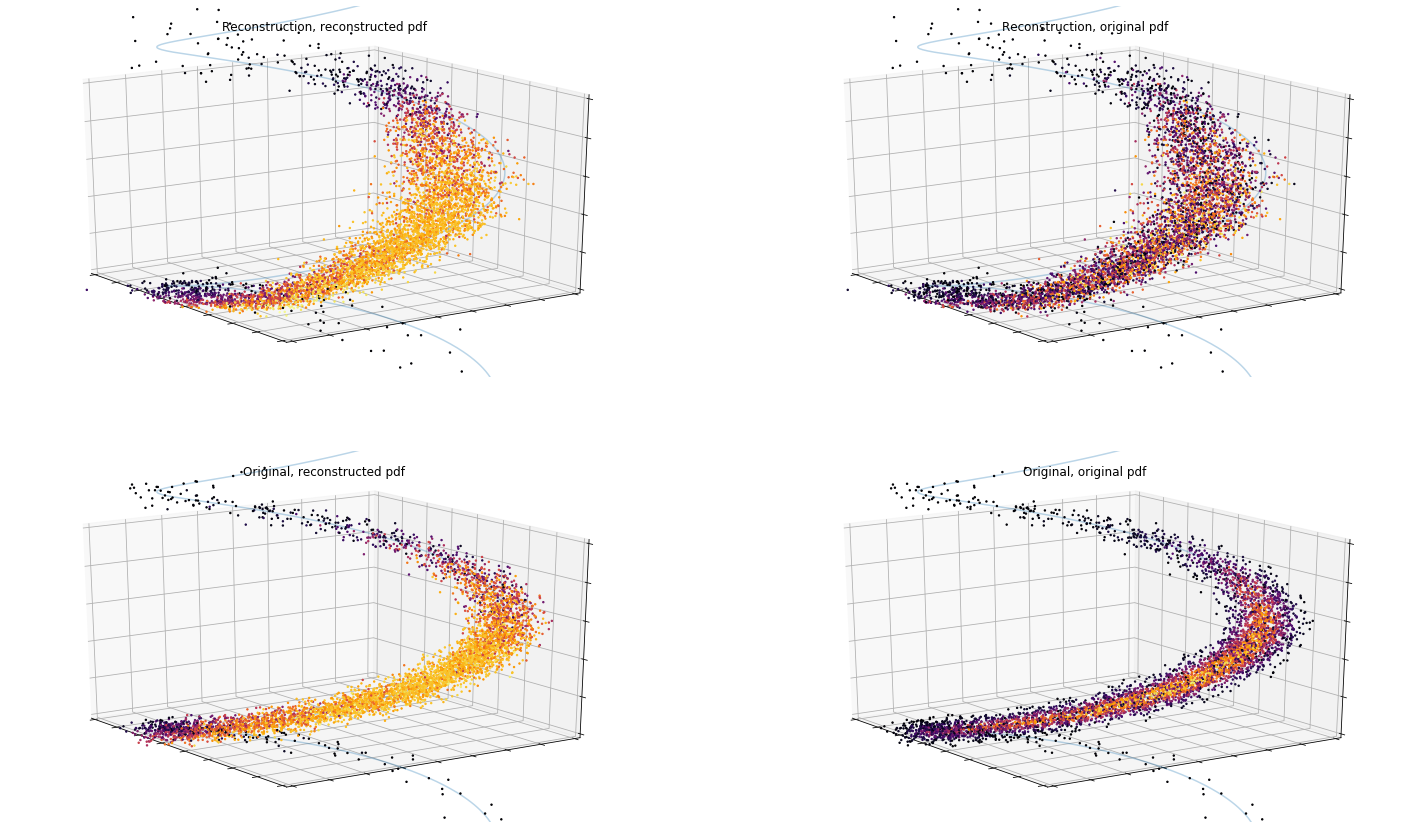

In [21]:
fig = plt.figure()
fig.set_size_inches(25, 15)
ax = fig.add_subplot(221, projection='3d')
ax = plot_data(fz, np.exp(log_pfz), ax)
ax.set_title('Reconstruction, reconstructed pdf')

ax = fig.add_subplot(222, projection='3d')
ax = plot_data(fz, np.exp(log_px), ax)
ax.set_title('Reconstruction, original pdf')

ax = fig.add_subplot(223, projection='3d')
ax = plot_data(x[:5000], np.exp(log_pfz), ax)
ax.set_title('Original, reconstructed pdf')

ax = fig.add_subplot(224, projection='3d')
ax = plot_data(x[:5000], np.exp(log_px), ax)
ax.set_title('Original, original pdf')